---
## 3. Collaborative Based Filtering with Surprise Library

Here, I will build a collaborative recommender system with Surprise library, the package that's commonly used to develop recommendation system using different algorithms.

In [1]:
#Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Read back the data that we save previously in the expected format (listing, reviewer, polarity score)
df = pd.read_csv('data/reviews_polarity.csv')

In Surprise library, we need a 'reader' object to load the data in the format that this library needs. 

In [3]:
#Import the library
from surprise import Reader
from surprise import Dataset

In [4]:
#Set the reader object and the data in the required format
my_reader = Reader(rating_scale=(0, 1)) #From the MinMaxScaler function before, we know that the scale is between 0 and 1
my_dataset = Dataset.load_from_df(df[['reviewer_id', 'listing_id', 'polarity']], my_reader)

In this library, there are a lot of algorithms that can be applied (https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html#module-surprise.prediction_algorithms). The famous one is SVD algorithm, that was used by Simon Funk during the Netflix Prize. It is basically a matrix factorization method. The other common algorithm is KNN. I am going to try multiple algorithms for the full dataset and pick the one with the best accuracy score. I will use RMSE(Root Mean Squared Error) as my accuracy metric for the predictions. Lower score means better accuracy.

##### Pick the best algorithm

In [5]:
#Import GridSearchCV from surprise for tune an algorithm and all the algorithms needed
from surprise.model_selection import GridSearchCV

#Import all the algoritgms
from surprise import NormalPredictor
from surprise import BaselineOnly

from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline

from surprise import SVD
from surprise import SVDpp

from surprise import SlopeOne
from surprise import CoClustering

#Import cross_validate to tune the algorithm
from surprise.model_selection import cross_validate

In [6]:
#Set an empty list for the results from each algorithm
result = []
    
#Set the list of algorithms
algos = [NormalPredictor(), BaselineOnly(), 
         KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), 
         SVD(), SVDpp(),
         SlopeOne(), CoClustering()]

#Loop the algorithms
for algo in algos:
    #Get the algorithm name
    algo_name = str(algo).split(' ')[0].split('.')[-1]
    
    #Print the algo in process to see the progress during loop
    print(f'Starting: {algo_name}')
    
    #Perform 5-fold cross validation 
    cv = cross_validate(algo, my_dataset, measures=['RMSE'], cv=5, verbose=False)
    
    #Get the cross validation result and count the mean
    test_rmse = cv['test_rmse'].mean()
    
    #Put algo_name and test_rmse as a tupple into the list
    result.append((algo_name, test_rmse))

#Put all the results into dataframe
df_results = pd.DataFrame(result, columns = ['Algorithm' , 'RMSE Score'])

Starting: NormalPredictor
Starting: BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Starting: KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Starting: KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Starting: KNNWithZScore


In [7]:
#See the result
df_results

,Algorithm,RMSE Score
0,NormalPredictor,0.150224
1,BaselineOnly,0.104977
2,KNNBasic,0.108212
3,KNNWithMeans,0.125414
4,KNNWithZScore,0.126137
5,KNNBaseline,0.106617
6,SVD,0.137042
7,SVDpp,0.118534
8,SlopeOne,0.125613
9,CoClustering,0.634646


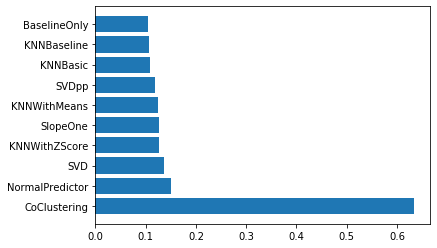

In [8]:
#Show the results in bar chart
df_results_sorted = df_results.set_index('Algorithm').sort_values(by='RMSE Score', ascending=False)
plt.figure()
plt.barh(df_results_sorted.index, df_results_sorted['RMSE Score'])
plt.show()

It seems that from our dataset, BaselineOnly and KNNBaseline are the two best options. Now I will try to optimize the parameter for both algorithms.

In [9]:
#BaselineOnly with ALS method

#Set the param grid
param_grid_ALS = {'bsl_options': {'method': ['als'],
                                  'reg_i': [10, 15, 20],
                                  'reg_u': [5, 10, 15],
                                  'n_epochs': [5, 10]
                                 }
                 }

#Set the GridSearchCV
GS_ALS = GridSearchCV(BaselineOnly, param_grid_ALS, measures=['rmse'], cv=5)

#Fit the dataset
GS_ALS.fit(my_dataset)

#Print best RMSE score
print(GS_ALS.best_score['rmse'])

#Print the best combination of parameters
print(GS_ALS.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [10]:
#BaselineOnly with SGD method

#Set the param grid
param_grid_SGD = {'bsl_options': {'method': ['sgd'],
                                  'reg': [0.02, 0.05, 0.1],
                                  'learning_rate': [0.005, 0.01],
                                  'n_epochs': [10, 15]
                                 }
                 }

#Set the GridSearchCV
GS_SGD = GridSearchCV(BaselineOnly, param_grid_SGD, measures=['rmse'], cv=5)

#Fit the dataset
GS_SGD.fit(my_dataset)

#Print best RMSE score
print(GS_SGD.best_score['rmse'])

#Print the best combination of parameters
print(GS_SGD.best_params['rmse'])

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

In [11]:
#KNNBaseline

#Set the param grid
param_grid_KNN = {'k': [5, 10],
                  'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                                  'user_based': [False]}
                  }

#Set the GridSearchCV
GS_KNN = GridSearchCV(KNNBaseline, param_grid_KNN, measures=['rmse'], cv=5)

#Fit the dataset
GS_KNN.fit(my_dataset)

#Print best RMSE score
print(GS_KNN.best_score['rmse'])

#Print the best combination of parameters
print(GS_KNN.best_params['rmse'])


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...


C:\Users\reyna\anaconda3\envs\plotly_bokeh\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similari

From the simulations, our best choice is BaselineOnly algorithm (RMSE Score = 0.1036) with parameter:
- method: als
- reg_i: 20
- reg_u: 5
- n_epochs: 5

Since we already have the best algorithm and parameter option, now I will build the model based on train and test data, and see the accuracy of test data.

##### Baseline Only

In [18]:
#Import the train_test_split
from surprise.model_selection import train_test_split
from surprise import accuracy

#Do sample random trainset and testset, test set is made of 25% of the ratings
trainset, testset = train_test_split(my_dataset, test_size=0.25)

#Set the hyperparameter
bsl_options = {'method': 'als',
               'reg_i': 20,
               'reg_u': 5,
               'n_epochs': 5
              }

#Set my model from the train set
my_model = BaselineOnly(bsl_options=bsl_options)

#Fit the model
my_model.fit(trainset)

#Test the model for our test set
my_prediction = my_model.test(testset)

#Check the RMSE score
accuracy.rmse(my_prediction)

Estimating biases using als...
RMSE: 0.1043


0.10429853656341578

After we run the model on our test set, we can see the results of the prediction.

In [7]:
#Put the prediction results into a dataframe
df_prediction = pd.DataFrame(my_prediction, columns=['reviewer_id', 'listing_id', 'actual', 'prediction', 'details'])
df_prediction.head()

,reviewer_id,listing_id,actual,prediction,details
0,54918285,16934327,0.681481,0.713638,{'was_impossible': False}
1,20375362,17075234,0.802083,0.729011,{'was_impossible': False}
2,7759385,8170591,0.791667,0.725162,{'was_impossible': False}
3,17788073,16232948,0.739815,0.709377,{'was_impossible': False}
4,119992463,37889643,0.707222,0.715750,{'was_impossible': False}


We can count the difference between actual and prediction score.

In [8]:
#Count the difference and put it into a column
df_prediction['diff'] = abs(df_prediction['prediction'] - df_prediction['actual'])
df_prediction.head()

,reviewer_id,listing_id,actual,prediction,details,diff
0,54918285,16934327,0.681481,0.713638,{'was_impossible': False},0.032156
1,20375362,17075234,0.802083,0.729011,{'was_impossible': False},0.073073
2,7759385,8170591,0.791667,0.725162,{'was_impossible': False},0.066505
3,17788073,16232948,0.739815,0.709377,{'was_impossible': False},0.030438
4,119992463,37889643,0.707222,0.715750,{'was_impossible': False},0.008527


Now we can see the top 10 best or worst prediction.

In [9]:
#See the top 10 best prediction
df_prediction.sort_values(by='diff')[:10]

,reviewer_id,listing_id,actual,prediction,details,diff
620,12481554,7071924,0.716328,0.716335,{'was_impossible': False},0.000007
4016,143523369,21867512,0.719167,0.719135,{'was_impossible': False},0.000031
3736,2138942,24183385,0.738385,0.738347,{'was_impossible': False},0.000038
6734,157092888,15735770,0.693472,0.693426,{'was_impossible': False},0.000046
2202,36480213,5104823,0.706061,0.705972,{'was_impossible': False},0.000089
4404,53774508,36074926,0.721944,0.722046,{'was_impossible': False},0.000102
79,246703413,21577211,0.722340,0.722237,{'was_impossible': False},0.000103
3537,28712299,40594850,0.704762,0.704646,{'was_impossible': False},0.000116
2734,1401996,5642121,0.709444,0.709320,{'was_impossible': False},0.000125
6739,4587413,19208688,0.691204,0.691060,{'was_impossible': False},0.000143


In [10]:
#See the top 10 worst prediction
df_prediction.sort_values(by='diff')[-10:]

,reviewer_id,listing_id,actual,prediction,details,diff
4561,83264932,6798565,1.000000,0.674369,{'was_impossible': False},0.325631
5398,21027063,40971016,1.000000,0.673524,{'was_impossible': False},0.326476
4134,343156130,24535259,0.375000,0.709272,{'was_impossible': False},0.334272
4949,287433552,20559146,1.000000,0.664100,{'was_impossible': False},0.335900
6108,146834788,36695025,0.427885,0.765184,{'was_impossible': False},0.337300
145,27880976,33159190,0.369792,0.712953,{'was_impossible': False},0.343162
1632,130864801,13980504,0.335938,0.714374,{'was_impossible': False},0.378436
6608,26716757,5347437,0.353333,0.732376,{'was_impossible': False},0.379043
333,102229093,12874057,0.150000,0.681952,{'was_impossible': False},0.531952
920,205672886,29039381,0.062500,0.720179,{'was_impossible': False},0.657679


We can see the difference of top 10 best prediction is pretty small, 0.000xxx. Even for the majority of worst prediction, the difference is around 0.3. Not too bad. Now we can build a full model using the whole dataset, and build a recommender function on top of it.

In [12]:
#Train the full dataset

#Set the full trainset
fulltrainset = my_dataset.build_full_trainset()

#Set the parameter
bsl_options: {'method': 'als',
              'reg_i': 20,
              'reg_u': 5,
              'n_epochs': 5
             }

#Set my model from the full train set
my_model_fin = BaselineOnly(bsl_options=bsl_options)

#Fit the model with my full train set
my_model_fin.fit(fulltrainset)

Estimating biases using als...


In [13]:
#Build a test set for all pairs (reviewers and listings) that are NOT in the training set using build_anti_testset function
my_testset = fulltrainset.build_anti_testset()

In [14]:
#Get the results (Note: need almost 1 hour process and need high memory space)
my_fin_prediction = my_model_fin.test(my_testset)

In [10]:
from collections import defaultdict

#Function to get top n given the predictions dataset (from https://surprise.readthedocs.io/en/stable/FAQ.html)
def get_top_n(predictions, n=3):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [15]:
#Get the top 3 listing recommendation for each reviewer
top_n = get_top_n(my_fin_prediction, n=3)

In [16]:
top_n

defaultdict(list,
            {825299: [(21564437, 0.7737501061578398),
              (32172374, 0.7705687584079618),
              (22925127, 0.7682973479452453)],
             1914168: [(21564437, 0.7974958010588334),
              (32172374, 0.7943144533089554),
              (22925127, 0.7920430428462389)],
             3014596: [(21564437, 0.7563121242918125),
              (32172374, 0.7531307765419345),
              (22925127, 0.750859366079218)],
             55586890: [(21564437, 0.742905930103266),
              (32172374, 0.739724582353388),
              (22925127, 0.7374531718906715)],
             6442534: [(21564437, 0.7492307155673138),
              (32172374, 0.7460493678174358),
              (22925127, 0.7437779573547193)],
             13039733: [(21564437, 0.766258924812164),
              (32172374, 0.763077577062286),
              (22925127, 0.7608061665995695)],
             47060829: [(21564437, 0.7471770768974537),
              (32172374, 0.743995729147575

Wow, all the reviewers get the same results of the listings! Although the prediction scores are different, but they got the same list in the same order. It seems that even though this algorithm has the least RMSE score, it predicts the same order given the users and items. This algorithm predicting the baseline estimate for given user and item. Obviously we can't use it for our recommender system. In that case, I will try KNN Baseline as our next best algorithm.

##### KNN Baseline

In [20]:
#Do sample random trainset and testset, test set is made of 25% of the ratings
trainset_KNN, testset_KNN = train_test_split(my_dataset, test_size=0.25)

#From the previous KNN Baseline simulation, we already know the optimum parameter
sim_options = {'name': 'pearson_baseline', 'user_based': False}

#Set my model from the train set
my_model_KNN = KNNBaseline(k = 5, sim_options = sim_options)

#Fit the model
my_model_KNN.fit(trainset_KNN)

#Test the model for our test set
my_prediction_KNN = my_model_KNN.test(testset_KNN)

#Check the RMSE score
accuracy.rmse(my_prediction_KNN)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1060


0.10598764431198358

In [21]:
#Put into a dataframe and count the difference of actual and prediction
df_prediction_KNN = pd.DataFrame(my_prediction_KNN, columns=['reviewer_id', 'listing_id', 'actual', 'prediction', 'details'])
df_prediction_KNN['diff'] = abs(df_prediction_KNN['prediction'] - df_prediction_KNN['actual'])
df_prediction_KNN

,reviewer_id,listing_id,actual,prediction,details,diff
0,115280504,19744355,0.746875,0.715707,"{'actual_k': 0, 'was_impossible': False}",0.031168
1,39663334,34655839,0.873594,0.725360,{'was_impossible': False},0.148234
2,286535421,16947736,0.627778,0.742367,"{'actual_k': 0, 'was_impossible': False}",0.114589
3,36083360,7094995,0.715174,0.726086,"{'actual_k': 0, 'was_impossible': False}",0.010912
4,20970563,249106,0.787500,0.713841,"{'actual_k': 0, 'was_impossible': False}",0.073659
...,...,...,...,...,...,...
6772,296457,4706507,0.707273,0.684713,"{'actual_k': 0, 'was_impossible': False}",0.022560
6773,2755295,4747128,0.735714,0.712888,"{'actual_k': 0, 'was_impossible': False}",0.022826
6774,126227107,10619890,0.800000,0.680185,"{'actual_k': 0, 'was_impossible': False}",0.119815
6775,8175973,32842155,0.579271,0.710012,{'was_impossible': False},0.130741


In [23]:
#See the top 10 best prediction
df_prediction_KNN.sort_values(by='diff')[:10]

,reviewer_id,listing_id,actual,prediction,details,diff
1393,112967302,13205734,0.708333,0.708340,"{'actual_k': 0, 'was_impossible': False}",0.000007
4391,31222768,7717732,0.656548,0.656581,"{'actual_k': 0, 'was_impossible': False}",0.000034
2885,241021605,25947820,0.697292,0.697251,"{'actual_k': 0, 'was_impossible': False}",0.000041
689,199563345,24310129,0.710547,0.710506,"{'actual_k': 0, 'was_impossible': False}",0.000041
481,35040369,1417881,0.704167,0.704229,"{'actual_k': 0, 'was_impossible': False}",0.000062
5735,43767511,4942126,0.692584,0.692506,{'was_impossible': False},0.000078
6536,148612880,20247256,0.727083,0.726996,"{'actual_k': 0, 'was_impossible': False}",0.000088
2326,8815457,26418037,0.720139,0.720027,{'was_impossible': False},0.000112
5772,74532481,7548858,0.701429,0.701596,"{'actual_k': 0, 'was_impossible': False}",0.000167
5142,274369419,30112138,0.696296,0.696129,"{'actual_k': 0, 'was_impossible': False}",0.000168


In [25]:
#See the top 10 worst prediction
df_prediction_KNN.sort_values(by='diff')[-10:]

,reviewer_id,listing_id,actual,prediction,details,diff
1881,11790653,18526737,0.354167,0.714993,"{'actual_k': 0, 'was_impossible': False}",0.360827
455,99909424,41553128,0.350000,0.728215,{'was_impossible': False},0.378215
4720,155840064,14757196,0.968750,0.528778,"{'actual_k': 1, 'was_impossible': False}",0.439972
1549,253370454,40474726,0.275000,0.720813,{'was_impossible': False},0.445813
1806,190884050,32844342,0.297500,0.744625,"{'actual_k': 0, 'was_impossible': False}",0.447125
4953,51407599,26928315,0.250000,0.711417,"{'actual_k': 0, 'was_impossible': False}",0.461417
5500,145869703,40471079,0.250000,0.725412,"{'actual_k': 0, 'was_impossible': False}",0.475412
4356,19838101,874731,0.200000,0.712956,{'was_impossible': False},0.512956
173,126057352,13429931,0.150000,0.672421,{'was_impossible': False},0.522421
911,164153431,13383325,0.000000,0.679183,"{'actual_k': 0, 'was_impossible': False}",0.679183


The different for the worst is around 0.4. Let's see the percentage for difference that are less than 0.1.

In [38]:
df_prediction_KNN[df_prediction_KNN['diff'] <= 0.1]

,reviewer_id,listing_id,actual,prediction,details,diff
0,115280504,19744355,0.746875,0.715707,"{'actual_k': 0, 'was_impossible': False}",0.031168
3,36083360,7094995,0.715174,0.726086,"{'actual_k': 0, 'was_impossible': False}",0.010912
4,20970563,249106,0.787500,0.713841,"{'actual_k': 0, 'was_impossible': False}",0.073659
5,1105691,1162198,0.728646,0.714937,"{'actual_k': 0, 'was_impossible': False}",0.013709
6,37089295,18670256,0.711429,0.726534,{'was_impossible': False},0.015106
...,...,...,...,...,...,...
6769,27503755,24876227,0.667667,0.684939,"{'actual_k': 0, 'was_impossible': False}",0.017273
6770,77632949,14828137,0.691111,0.693547,"{'actual_k': 0, 'was_impossible': False}",0.002436
6772,296457,4706507,0.707273,0.684713,"{'actual_k': 0, 'was_impossible': False}",0.022560
6773,2755295,4747128,0.735714,0.712888,"{'actual_k': 0, 'was_impossible': False}",0.022826


In [39]:
df_prediction_KNN[df_prediction_KNN['diff'] <= 0.1]['reviewer_id'].count() / df_prediction_KNN['reviewer_id'].count()

0.7068024199498303

It is good. 71% of the difference is less or equal to 0.1. Now we can train the whole dataset.

In [9]:
#Train the full dataset

#Set the full trainset
fulltrainset_KNN = my_dataset.build_full_trainset()

sim_options = {'name': 'pearson_baseline', 'user_based': False}

#Set my model from the full train set
my_model_fin_KNN = KNNBaseline(k = 5, sim_options = sim_options)

#Fit the model with my full train set
my_model_fin_KNN.fit(fulltrainset_KNN)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [10]:
#Define the full test set
fulltestset_KNN = fulltrainset_KNN.build_anti_testset()

In [11]:
#Set the prediction (Note: need almost 1 hour process and require large memory space)
my_fin_prediction_KNN = my_model_fin_KNN.test(fulltestset_KNN)

In [13]:
#Get top 3 for all users
top_n_KNN = get_top_n(my_fin_prediction_KNN, n=3)

In [14]:
top_n_KNN

defaultdict(list,
            {825299: [(40086393, 0.7779343556615791),
              (21564437, 0.7754443409101475),
              (38236844, 0.7753612325623368)],
             1914168: [(4244379, 0.8821615848507822),
              (25369132, 0.8788824818077459),
              (40086393, 0.7929828348281709)],
             3014596: [(40086393, 0.7701156225027195),
              (21564437, 0.7676256077512877),
              (38236844, 0.7675424994034772)],
             55586890: [(40086393, 0.7661696385935047),
              (21564437, 0.7636796238420731),
              (38236844, 0.7635965154942624)],
             6442534: [(40086393, 0.7680271275312609),
              (21564437, 0.7655371127798292),
              (38236844, 0.7654540044320186)],
             13039733: [(40086393, 0.7762122177263208),
              (21564437, 0.7737222029748891),
              (38236844, 0.7736390946270785)],
             47060829: [(40086393, 0.767831464409616),
              (21564437, 0.765341449658

Although I can see 1 difference, the rest of the results are the same! This algorithm uses nearest neighbors approach. This is not a good recommender system for the dataset considering the results. Let's try SVD, another different method (matrix factorization) and the most widely use collaborative recommender algorithm.

##### SVD

First, find the best parameter.

In [7]:
#Set the parameter grid
param_grid_SVD = {'n_epochs': [5, 10], 
                  'lr_all': [0.002, 0.005,0.1],
                  'reg_all': [0.4, 0.6], 
                  'n_factors':[100,500]}

#Set GridSearchCV
GS_SVD = GridSearchCV(SVD, param_grid_SVD, measures=['RMSE'], cv=5)

#Fit the model
GS_SVD.fit(my_dataset)


In [8]:
print(GS_SVD.best_score['rmse'])

0.10681877048346619


In [9]:
print(GS_SVD.best_params['rmse'])

{'n_epochs': 5, 'lr_all': 0.1, 'reg_all': 0.6, 'n_factors': 100}


I will use above parameters for the train and test set.

In [10]:
#Import the train_test_split
from surprise.model_selection import train_test_split
from surprise import accuracy

#Do sample random trainset and testset, test set is made of 25% of the ratings
trainset_SVD, testset_SVD = train_test_split(my_dataset, test_size=0.25)

#Set my model from the train set
my_model_SVD = SVD(n_epochs=5, lr_all=0.1, reg_all=0.6, n_factors=100)

#Fit the model
my_model_SVD.fit(trainset_SVD)

#Test the model for our test set
my_prediction_SVD = my_model_SVD.test(testset_SVD)

#Check the RMSE score
accuracy.rmse(my_prediction_SVD)

RMSE: 0.1062


0.10622525419380988

The RMSE score is not bad. Now let's see the best and worst prediction.

In [11]:
#Put into dataframe
df_prediction_SVD = pd.DataFrame(my_prediction_SVD, columns=['reviewer_id', 'listing_id', 'actual', 'prediction', 'details'])

#Count the difference and put it into a column
df_prediction_SVD['diff'] = abs(df_prediction_SVD['prediction'] - df_prediction_SVD['actual'])

df_prediction_SVD

,reviewer_id,listing_id,actual,prediction,details,diff
0,13712253,15390640,0.762000,0.748871,{'was_impossible': False},0.013129
1,143690306,18829637,0.894444,0.714505,{'was_impossible': False},0.179939
2,7442281,18657916,0.707917,0.763292,{'was_impossible': False},0.055376
3,87608342,19035665,0.702778,0.721022,{'was_impossible': False},0.018244
4,217842982,28857943,0.640000,0.692684,{'was_impossible': False},0.052684
...,...,...,...,...,...,...
6772,114554292,7717809,0.773333,0.701348,{'was_impossible': False},0.071985
6773,210164562,1714639,0.571429,0.611337,{'was_impossible': False},0.039909
6774,172964158,125176,0.713426,0.653573,{'was_impossible': False},0.059852
6775,157478819,39849788,0.793646,0.711293,{'was_impossible': False},0.082353


In [12]:
#See the top 10 best prediction
df_prediction_SVD.sort_values(by='diff')[:10]

,reviewer_id,listing_id,actual,prediction,details,diff
2891,91205934,6975013,0.750000,0.750021,{'was_impossible': False},0.000021
5919,160278842,23294537,0.716667,0.716603,{'was_impossible': False},0.000063
1025,7313602,4550506,0.697092,0.697002,{'was_impossible': False},0.000090
3906,81777620,5642121,0.692593,0.692501,{'was_impossible': False},0.000092
3449,5104973,24293792,0.751736,0.751833,{'was_impossible': False},0.000097
3018,165120431,40158673,0.684028,0.683929,{'was_impossible': False},0.000099
5845,37422770,7347721,0.641667,0.641767,{'was_impossible': False},0.000100
2396,61138616,13383325,0.664583,0.664693,{'was_impossible': False},0.000110
3325,1905348,21486270,0.736667,0.736530,{'was_impossible': False},0.000137
5256,43819868,11906047,0.766667,0.766923,{'was_impossible': False},0.000257


In [13]:
#See the top 10 worst prediction
df_prediction_SVD.sort_values(by='diff')[-10:]

,reviewer_id,listing_id,actual,prediction,details,diff
1497,110209436,1759915,1.0000,0.624474,{'was_impossible': False},0.375526
2491,254352511,11424428,0.9500,0.571600,{'was_impossible': False},0.378400
5411,89326395,13284465,1.0000,0.619716,{'was_impossible': False},0.380284
2771,65925968,28345422,0.5000,0.884687,{'was_impossible': False},0.384687
1493,189551463,31521107,0.3500,0.742333,{'was_impossible': False},0.392333
4687,99909424,41553128,0.3500,0.766103,{'was_impossible': False},0.416103
1707,126633025,7717732,0.2500,0.675182,{'was_impossible': False},0.425182
6499,131308434,26204770,0.3375,0.763914,{'was_impossible': False},0.426414
4400,19838101,874731,0.2000,0.685061,{'was_impossible': False},0.485061
3925,7034666,23885617,0.2500,0.759722,{'was_impossible': False},0.509722


The different for the worst is around 0.4. Let see the percentage for difference that are less than 0.1.

In [14]:
df_prediction_SVD[df_prediction_SVD['diff'] <= 0.1]

,reviewer_id,listing_id,actual,prediction,details,diff
0,13712253,15390640,0.762000,0.748871,{'was_impossible': False},0.013129
2,7442281,18657916,0.707917,0.763292,{'was_impossible': False},0.055376
3,87608342,19035665,0.702778,0.721022,{'was_impossible': False},0.018244
4,217842982,28857943,0.640000,0.692684,{'was_impossible': False},0.052684
6,43209438,1418910,0.649107,0.675466,{'was_impossible': False},0.026359
...,...,...,...,...,...,...
6772,114554292,7717809,0.773333,0.701348,{'was_impossible': False},0.071985
6773,210164562,1714639,0.571429,0.611337,{'was_impossible': False},0.039909
6774,172964158,125176,0.713426,0.653573,{'was_impossible': False},0.059852
6775,157478819,39849788,0.793646,0.711293,{'was_impossible': False},0.082353


In [15]:
df_prediction_SVD[df_prediction_SVD['diff'] <= 0.1]['reviewer_id'].count() / df_prediction_SVD['reviewer_id'].count()

0.697801387044415

It is still good. 69% of the difference is less or equal to 0.1. Now we can train the whole dataset.

In [6]:
#Train the full dataset

#Set the full trainset
fulltrainset_SVD = my_dataset.build_full_trainset()

#Set my model from the full train set
my_model_fin_SVD = SVD(n_epochs=5, lr_all=0.1, reg_all=0.6, n_factors=100)

#Fit the model with my full train set
my_model_fin_SVD.fit(fulltrainset_SVD)

In [7]:
#Define the full test set
fulltestset_SVD = fulltrainset_SVD.build_anti_testset()

In [8]:
#Set the prediction (Note: need almost 1 hour process and require large memory space)
my_fin_prediction_SVD = my_model_fin_SVD.test(fulltestset_SVD)

In [11]:
#Get top 3 for all users
top_n_SVD = get_top_n(my_fin_prediction_SVD, n=3)

In [12]:
#See the top 3
top_n_SVD

defaultdict(list,
            {825299: [(40071187, 0.8865166490156504),
              (34721612, 0.8609911078803665),
              (31646440, 0.8600521503062578)],
             1914168: [(37365549, 0.8703788629670001),
              (24961531, 0.860875811942871),
              (40071187, 0.8583238539656507)],
             3014596: [(42003657, 0.8882590610351425),
              (33785763, 0.878361284448544),
              (37162330, 0.878051302671399)],
             55586890: [(24961531, 0.8352843268922449),
              (33785763, 0.8336219301876505),
              (39024360, 0.8271815655312242)],
             6442534: [(40071187, 0.8154951990035918),
              (18776875, 0.8098436569055316),
              (42201587, 0.8096914097948079)],
             13039733: [(37365549, 0.8910225562733721),
              (27225525, 0.8783658451261653),
              (40071187, 0.8730993374417553)],
             47060829: [(40071187, 0.8611576369577251),
              (42044088, 0.8582910592145

It looks good! We have more variance in the data with higher polarity score, althought the RMSE score is higher than BaselineOnly. The logic behind this algorithm is matrix factorization. It predicts the missing score in the user-item matrix. We know that PCA (Principal Component Analysis) is used for dimensional reduction. In addition to that, the benefit of PCA is that we can get the latent factors of the data. With SVD, it is basically doing the same thing with PCA, but directly on users matrix and items matrix at the same time to get the latent factors, and do a diagonal matrix to give a prediction score based on the latent factors. 

We can use this model as our final collaborative filtering recommender system. Worth to note that this modelling is hard to interpret and this is not applicable for cold start scenario, when there is a new listing or a new user.

As my final conclusion, considering the dataset that we have where majority of users only have 1 review, recommender system using content based filtering will be more applicable. Cold start situation also can be applicable here. Majority of the Airbnb users are tourists who never comes to that city or only a few times, hence small amount of reviews per user for the modelling. Remember that for this modelling, I removed majority of the data due to lack of total reviews per user. But, we still can use this collaborative modeling to give recommendation based on preference from other users, as long we have the data where a user have review for many listings.

To showcase my model, I will build a Streamlit apps where we can simulate those scenarios.

In [15]:
#Import the top 3 recommendation data from each users for my Streamlit apps
import joblib
joblib.dump(top_n_SVD, "top_n_SVD.pkl")

['top_n_SVD.pkl']

---
##### END
---